Ref:https://www.kaggle.com/nxrprime/wavenet-with-shifted-rfc-proba-and-cbr

In [1]:
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow.keras.layers import *
import pandas as pd
import numpy as np
import random
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import losses, models, optimizers
import tensorflow_addons as tfa
import gc

from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
# -*- coding- utf-8 -*-
#google driveのフォルダに接続
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# configurations and main hyperparammeters
EPOCHS = 180
NNBATCHSIZE = 32 #16
GROUP_BATCH_SIZE = 4000
SEED = 71
LR = 0.0015
SPLITS = 6

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [0]:
# read data
def read_data():
    train = pd.read_csv('drive/My Drive/train_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv('drive/My Drive/test_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv('drive/My Drive/sample_submission.csv', dtype={'time': np.float32})
    #train = pd.read_csv('/kaggle/input/data-without-drift/train_clean.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    #test  = pd.read_csv('/kaggle/input/data-without-drift/test_clean.csv', dtype={'time': np.float32, 'signal': np.float32})
    #sub  = pd.read_csv('/kaggle/input/liverpool-ion-switching/sample_submission.csv', dtype={'time': np.float32})
    
    Y_train_proba = np.load("drive/My Drive/Y_train_proba.npy")
    Y_test_proba = np.load("drive/My Drive/Y_test_proba.npy")
    #Y_train_proba = np.load("/kaggle/input/ion-shifted-rfc-proba/Y_train_proba.npy")
    #Y_test_proba = np.load("/kaggle/input/ion-shifted-rfc-proba/Y_test_proba.npy")
    
    for i in range(11):
        train[f"proba_{i}"] = Y_train_proba[:, i]
        test[f"proba_{i}"] = Y_test_proba[:, i]

    return train, test, sub

# create batches of 4000 observations
def batching(df, batch_size):
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
    return df

# normalize the data (standard scaler). We can also try other scalers for a better score!
def normalize(train, test):
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal - train_input_mean) / train_input_sigma
    test['signal'] = (test.signal - train_input_mean) / train_input_sigma
    return train, test

# get lead and lags features
def lag_with_pct_change(df, windows):
    for window in windows:    
        df['signal_shift_pos_' + str(window)] = df.groupby('group')['signal'].shift(window).fillna(0)
        df['signal_shift_neg_' + str(window)] = df.groupby('group')['signal'].shift(-1 * window).fillna(0)
    return df

# main module to run feature engineering. Here you may want to try and add other features and check if your score imporves :).
def run_feat_engineering(df, batch_size):
    # create batches
    df = batching(df, batch_size = batch_size)
    # create leads and lags (1, 2, 3 making them 6 features)
    df = lag_with_pct_change(df, [1, 2, 3])
    # create signal ** 2 (this is the new feature)
    df['signal_2'] = df['signal'] ** 2
    return df

# fillna with the mean and select features for training
def feature_selection(train, test):
    features = [col for col in train.columns if col not in ['index', 'group', 'open_channels', 'time']]
    train = train.replace([np.inf, -np.inf], np.nan)
    test = test.replace([np.inf, -np.inf], np.nan)
    for feature in features:
        feature_mean = pd.concat([train[feature], test[feature]], axis = 0).mean()
        train[feature] = train[feature].fillna(feature_mean)
        test[feature] = test[feature].fillna(feature_mean)
    return train, test, features

# model function (very important, you can try different arquitectures to get a better score. I believe that top public leaderboard is a 1D Conv + RNN style)
def Classifier(shape_):
    
    def cbr(x, out_layer, kernel, stride, dilation):
        x = Conv1D(out_layer, kernel_size=kernel, dilation_rate=dilation, strides=stride, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        return x
    
    def wave_block(x, filters, kernel_size, n):
        dilation_rates = [2**i for i in range(n)]
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = x
        for dilation_rate in dilation_rates:
            tanh_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same', 
                              activation = 'tanh', 
                              dilation_rate = dilation_rate)(x)
            sigm_out = Conv1D(filters = filters,
                              kernel_size = kernel_size,
                              padding = 'same',
                              activation = 'sigmoid', 
                              dilation_rate = dilation_rate)(x)
            x = Multiply()([tanh_out, sigm_out])
            x = Conv1D(filters = filters,
                       kernel_size = 1,
                       padding = 'same')(x)
            res_x = Add()([res_x, x])
        return res_x
    
    inp = Input(shape = (shape_))
    x = cbr(inp, 64, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 16, 3, 12)
    x = BatchNormalization()(x)
    x = wave_block(x, 32, 3, 8)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 4)
    x = BatchNormalization()(x)
    x = wave_block(x, 128, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = wave_block(x, 64, 3, 1)
    x = cbr(x, 32, 7, 1, 1)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    out = Dense(11, activation = 'softmax', name = 'out')(x)
    
    model = models.Model(inputs = inp, outputs = out)
    
    opt = Adam(lr = LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss = losses.CategoricalCrossentropy(), optimizer = opt, metrics = ['accuracy'])
    return model

# function that decrease the learning as epochs increase (i also change this part of the code)
def lr_schedule(epoch):
    if epoch < 30:
        lr = LR
    elif epoch < 40:
        lr = LR / 3
    elif epoch < 50:
        lr = LR / 5
    elif epoch < 60:
        lr = LR / 7
    elif epoch < 70:
        lr = LR / 9
    elif epoch < 80:
        lr = LR / 11
    elif epoch < 90:
        lr = LR / 13
    else:
        lr = LR / 100
    return lr

# class to get macro f1 score. This is not entirely necessary but it's fun to check f1 score of each epoch (be carefull, if you use this function early stopping callback will not work)
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis = 2).reshape(-1)
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis = 2).reshape(-1)
        score = f1_score(self.targets, pred, average = 'macro')
        print(f'F1 Macro Score: {score:.5f}')

In [0]:
#main function to perfrom groupkfold cross validation (we have 1000 vectores of 4000 rows and 8 features (columns)). Going to make 5 groups with this subgroups.
def run_cv_model_by_batch(train, test, splits, batch_col, feats, sample_submission, nn_epochs, nn_batch_size):
    
    seed_everything(SEED)
    K.clear_session()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)
    oof_ = np.zeros((len(train), 11)) # build out of folds matrix with 11 columns, they represent our target variables classes (from 0 to 10)
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])    
        new_splits.append(new_split)
    #pivot target columns to transform the net to a multiclass classification estructure (you can also leave it in 1 vector with sparsecategoricalcrossentropy loss function)
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

    tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
    train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
    test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))

    for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        print(f'Our training dataset shape is {train_x.shape}')
        print(f'Our validation dataset shape is {valid_x.shape}')

        gc.collect()
        shape_ = (None, train_x.shape[2]) #input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
        model = Classifier(shape_)
        #using our lr_schedule function
        cb_lr_schedule = LearningRateScheduler(lr_schedule)
        model.fit(train_x,train_y,
                  epochs = nn_epochs,
                  callbacks = [cb_lr_schedule, MacroF1(model, valid_x, valid_y)], # adding custom evaluation metric for each epoch
                  batch_size = nn_batch_size,verbose = 2,
                  validation_data = (valid_x,valid_y))
        preds_f = model.predict(valid_x)
        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') # need to get the class with the biggest probability
        print(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        oof_[val_orig_idx,:] += preds_f
        te_preds = model.predict(test)
        model.save("model-wavenet.h5")
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / SPLITS
    #calculate the oof macro f1_score
    f1_score_ = f1_score(np.argmax(train_tr, axis = 2).reshape(-1),  np.argmax(oof_, axis = 1), average = 'macro') # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array (extracting the best class)
    print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')

    sample_submission['open_channels'] = np.argmax(preds_, axis = 1).astype(int)
    sample_submission.to_csv('submission_wavenet.csv', index=False, float_format='%.4f')

    #train["y_pred"]=oof_
    #train.to_csv('wavenet_keras_rev2_y_pred.csv', index=False, float_format='%.4f')

In [0]:
# this function run our entire program
def run_everything():
    
    print('Reading Data Started...')
    train, test, sample_submission = read_data()
    train, test = normalize(train, test)
    print('Reading and Normalizing Data Completed')
        
    print('Creating Features')
    print('Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size = GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size = GROUP_BATCH_SIZE)
    train, test, features = feature_selection(train, test)
    print('Feature Engineering Completed...')
        
    print(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started...')
    run_cv_model_by_batch(train, test, SPLITS, 'group', features, sample_submission, EPOCHS, NNBATCHSIZE)
    print('Training completed...')

In [0]:
# this function run our entire program
def run_everything_2():
    
    print('Reading Data Started...')
    train, test, sample_submission = read_data()
    train, test = normalize(train, test)
    print('Reading and Normalizing Data Completed')
        
    print('Creating Features')
    print('Feature Engineering Started...')
    train = run_feat_engineering(train, batch_size = GROUP_BATCH_SIZE)
    test = run_feat_engineering(test, batch_size = GROUP_BATCH_SIZE)
    train, test, features = feature_selection(train, test)
    print('Feature Engineering Completed...')
    return train, test, features, sample_submission

In [15]:
train, test, features, sample_submission = run_everything_2()

Reading Data Started...
Reading and Normalizing Data Completed
Creating Features
Feature Engineering Started...
Feature Engineering Completed...


In [12]:
train.head()

,time,signal,open_channels,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,proba_10,group,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_2
0,0.0001,-1.148772,0,0.966731,0.028343,0.004812,0.000114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,-1.184075,0.000000,-1.012891,0.000000,-1.298012,1.319677
1,0.0002,-1.184075,0,0.996045,0.003466,0.000426,0.000063,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.148772,-1.012891,0.000000,-1.298012,0.000000,-1.303999,1.402034
2,0.0003,-1.012891,0,0.976313,0.018989,0.004677,0.000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.184075,-1.298012,-1.148772,-1.303999,0.000000,-1.104036,1.025949
3,0.0004,-1.298012,0,0.996002,0.003625,0.000326,0.000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.012891,-1.303999,-1.184075,-1.104036,-1.148772,-1.123085,1.684836
4,0.0005,-1.303999,0,0.997465,0.002335,0.000158,0.000042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.298012,-1.104036,-1.012891,-1.123085,-1.184075,-1.082287,1.700413


In [16]:
train=train
test=test
splits=SPLITS
batch_col='group'
feats=features
sample_submission=sample_submission
nn_epochs=EPOCHS
nn_batch_size=NNBATCHSIZE

seed_everything(SEED)
K.clear_session()
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
tf.compat.v1.keras.backend.set_session(sess)
oof_ = np.zeros((len(train), 11)) # build out of folds matrix with 11 columns, they represent our target variables classes (from 0 to 10)
preds_ = np.zeros((len(test), 11))
target = ['open_channels']
group = train['group']
kf = GroupKFold(n_splits=5)
splits = [x for x in kf.split(train, train[target], group)]

new_splits = []
for sp in splits:
    new_split = []
    new_split.append(np.unique(group[sp[0]]))
    new_split.append(np.unique(group[sp[1]]))
    new_split.append(sp[1])    
    new_splits.append(new_split)
#pivot target columns to transform the net to a multiclass classification estructure (you can also leave it in 1 vector with sparsecategoricalcrossentropy loss function)
tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
target_cols = ['target_'+str(i) for i in range(11)]
train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))

for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
    train_x, train_y = train[tr_idx], train_tr[tr_idx]
    valid_x, valid_y = train[val_idx], train_tr[val_idx]
    print(f'Our training dataset shape is {train_x.shape}')
    print(f'Our validation dataset shape is {valid_x.shape}')

    gc.collect()
    shape_ = (None, train_x.shape[2]) #input is going to be the number of feature we are using (dimension 2 of 0, 1, 2)
    model = Classifier(shape_)
    #using our lr_schedule function
    cb_lr_schedule = LearningRateScheduler(lr_schedule)
    model.fit(train_x,train_y,
                  epochs = nn_epochs,
                  callbacks = [cb_lr_schedule, MacroF1(model, valid_x, valid_y)], # adding custom evaluation metric for each epoch
                  batch_size = nn_batch_size,verbose = 2,
                  validation_data = (valid_x,valid_y))
    preds_f = model.predict(valid_x)
    f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  np.argmax(preds_f, axis=2).reshape(-1), average = 'macro') # need to get the class with the biggest probability
    print(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
    preds_f = preds_f.reshape(-1, preds_f.shape[-1])
    oof_[val_orig_idx,:] += preds_f
    te_preds = model.predict(test)
    model.save("model-wavenet.h5")
    te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
    preds_ += te_preds / SPLITS
#calculate the oof macro f1_score
f1_score_ = f1_score(np.argmax(train_tr, axis = 2).reshape(-1),  np.argmax(oof_, axis = 1), average = 'macro') # axis 2 for the 3 Dimension array and axis 1 for the 2 Domension Array (extracting the best class)
print(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')

Our training dataset shape is (1000, 4000, 19)
Our validation dataset shape is (250, 4000, 19)
Epoch 1/180
F1 Macro Score: 0.48123
32/32 - 15s - loss: 0.8194 - accuracy: 0.7570 - val_loss: 1.2334 - val_accuracy: 0.7275 - lr: 0.0015
Epoch 2/180
F1 Macro Score: 0.67086
32/32 - 10s - loss: 0.3153 - accuracy: 0.9181 - val_loss: 1.0893 - val_accuracy: 0.8360 - lr: 0.0015
Epoch 3/180
F1 Macro Score: 0.83715
32/32 - 10s - loss: 0.1994 - accuracy: 0.9534 - val_loss: 0.8443 - val_accuracy: 0.9213 - lr: 0.0015
Epoch 4/180
F1 Macro Score: 0.91044
32/32 - 10s - loss: 0.1684 - accuracy: 0.9602 - val_loss: 0.6127 - val_accuracy: 0.9533 - lr: 0.0015
Epoch 5/180
F1 Macro Score: 0.91328
32/32 - 10s - loss: 0.1432 - accuracy: 0.9636 - val_loss: 0.3804 - val_accuracy: 0.9553 - lr: 0.0015
Epoch 6/180
F1 Macro Score: 0.92436
32/32 - 10s - loss: 0.1351 - accuracy: 0.9648 - val_loss: 0.2891 - val_accuracy: 0.9602 - lr: 0.0015
Epoch 7/180
F1 Macro Score: 0.93306
32/32 - 10s - loss: 0.1304 - accuracy: 0.9653 -

In [17]:
# -*- coding: utf-8 -*-
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #over 10000 byte data pick up
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                    group|  10000152|
|                     oof_| 440000112|
|                   preds_| 176000112|
|        sample_submission|  24000152|
|                     test| 304000128|
|                       tr|  65000152|
|                    train| 760000128|
|                 train_tr| 220000128|
|                  train_x| 608000128|
|                  train_y| 176000128|
|             val_orig_idx|   8000096|
|                  valid_x| 152000128|
|                  valid_y|  44000128|


In [0]:
sample_submission['open_channels'] = np.argmax(preds_, axis = 1).astype(int)
sample_submission.to_csv('submission_wavenet_rev2.csv', index=False, float_format='%.4f')

In [0]:
train = pd.read_csv('drive/My Drive/train_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})

In [25]:
train.head()

,time,signal,open_channels
0,0.0001,-2.760655,0
1,0.0002,-2.848034,0
2,0.0003,-2.424341,0
3,0.0004,-3.130037,0
4,0.0005,-3.144854,0


In [27]:
train["y_pred"]=np.argmax(oof_, axis = 1).astype(int)
train.head()

,time,signal,open_channels,y_pred
0,0.0001,-2.760655,0,0
1,0.0002,-2.848034,0,0
2,0.0003,-2.424341,0,0
3,0.0004,-3.130037,0,0
4,0.0005,-3.144854,0,0


In [0]:
train.to_csv('drive/My Drive/wavenet_keras_rev2_y_pred.csv', index=False, float_format='%.4f')

In [0]:
train_pred = train
test_pred  = sample_submission

In [31]:
train_pred.head()

,time,signal,open_channels,y_pred
0,0.0001,-2.760655,0,0
1,0.0002,-2.848034,0,0
2,0.0003,-2.424341,0,0
3,0.0004,-3.130037,0,0
4,0.0005,-3.144854,0,0


In [32]:
test_pred.head()

,time,open_channels
0,500.000092,0
1,500.000214,0
2,500.000305,0
3,500.000397,0
4,500.000488,0


In [0]:
# Showing Confusion Matrix
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(y_train_true, y_train_pred, title):
    figsize=(14,14)
    y_train_pred = y_train_pred.astype(int)
    cm = confusion_matrix(y_train_true, y_train_pred, labels=np.unique(y_train_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_train_true), columns=np.unique(y_train_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

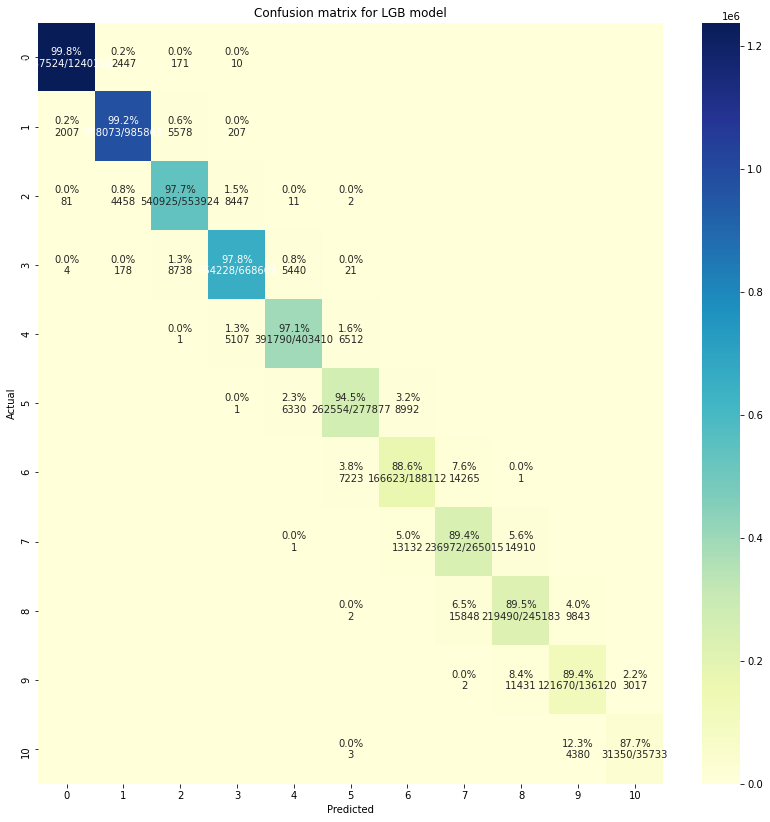

In [38]:
# Showing Confusion Matrix for LGB model
#plot_cm(y_train_true, y_train_pred, 'Confusion matrix for LGB model')
plot_cm(train_pred["open_channels"], train_pred["y_pred"], 'Confusion matrix for LGB model')

In [39]:
from sklearn.metrics import classification_report
target_names = ['0','1','2','3','4','5','6','7','8','9','10']
report = classification_report(train_pred["open_channels"], train_pred["y_pred"],target_names=target_names, digits= 4)
print(report)

              precision    recall  f1-score   support

           0     0.9983    0.9979    0.9981   1240152
           1     0.9928    0.9921    0.9925    985865
           2     0.9739    0.9765    0.9752    553924
           3     0.9794    0.9785    0.9789    668609
           4     0.9708    0.9712    0.9710    403410
           5     0.9502    0.9449    0.9475    277877
           6     0.8828    0.8858    0.8843    188112
           7     0.8872    0.8942    0.8907    265015
           8     0.8928    0.8952    0.8940    245183
           9     0.8953    0.8938    0.8946    136120
          10     0.9122    0.8773    0.8944     35733

    accuracy                         0.9682   5000000
   macro avg     0.9396    0.9370    0.9383   5000000
weighted avg     0.9683    0.9682    0.9683   5000000



In [0]:
train_5=train_pred[2000000:2500000]
train_10=train_pred[4500000:5000000]

In [44]:
from sklearn.metrics import f1_score
print('f1_batch_5', f1_score(train_5["open_channels"], train_5["y_pred"], average = 'macro'))
print('f1_batch_10', f1_score(train_10["open_channels"], train_10["y_pred"], average = 'macro'))
print("Bench mark score:0.84")

f1_batch_5 0.7534286839836724
f1_batch_10 0.7607960053491625
Bench mark score:0.84


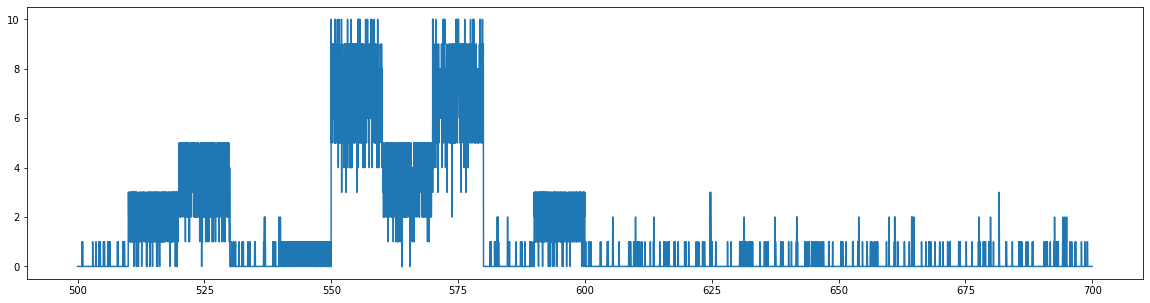

In [45]:
import matplotlib.pyplot as plt
res=200
plt.figure(figsize=(20,5))
plt.plot(test_pred.time[::res],test_pred.open_channels[::res])
plt.show()